In [17]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import extract_correct_csv
import neurokit2 as nk
import warnings
import biosppy
from scipy import interpolate


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [ ]:
columns = list(pd.read_csv('../osfstorage-archive/eye/pupil/Look002_pupil.csv', sep=';', decimal=',').columns)
col_ = ['expectancy', 'shock']
columns = columns + col_
generic_df = pd.DataFrame(columns=columns)
cur_sub = extract_correct_csv.read_correct_subject_csv(55)
subject = pd.read_csv('data/LookAtMe_0' + cur_sub + '.csv', sep='\t')
pupil_subj = pd.read_csv('../osfstorage-archive/eye/pupil/Look0' + cur_sub + '_pupil.csv', sep=';', decimal=',')
expectancy = np.array(list([int(d > 2) for d in subject['rating']]))
df_ = pupil_subj.copy(deep=False)
df_['expectancy'] = expectancy
df_['shock'] = subject['shock']
generic_df = pd.concat([generic_df, df_], axis=0)

generic_df = generic_df.reset_index().drop(columns=['index'])
# removing first 48 trial, keeping only generalization phase
generic_df = generic_df[48:]
baseline = generic_df.pd1.to_numpy()
mean_baseline = np.mean(baseline)
X = np.arange(-1, 6, 0.01)
# calculating mean and std of pupil diameter for
# - low exp and shock
df_LE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 0)]
df_LE_shock = df_LE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_1 = df_LE_shock.mean(axis=0)
all_conf_1 = df_LE_shock.var(axis=0)

# - low exp and no shock
df_LE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 0)]
df_LE_no_shock = df_LE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_2 = df_LE_no_shock.mean(axis=0)
all_conf_2 = df_LE_no_shock.std(axis=0)

# - high exp and shock
df_HE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 1)]
df_HE_shock = df_HE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_3 = df_HE_shock.mean(axis=0)
all_conf_3 = df_HE_shock.std(axis=0)

# - high exp and no shock
df_HE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 1)]
df_HE_no_shock = df_HE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_4 = df_HE_no_shock.mean(axis=0)
all_conf_4 = df_HE_no_shock.std(axis=0)

from matplotlib.pyplot import figure

figure(figsize=(8, 6))
LE_shock_line = plt.plot(X, all_mean_1, 'r-', label='Low exp - shock')
LE_shock_fill = plt.fill_between(X, all_mean_1 - all_conf_1, all_mean_1 + all_conf_1, color='r', alpha=0.06)

LE_no_line = plt.plot(X, all_mean_2, 'tomato', label='Low exp - no shock')
LE_no_fill = plt.fill_between(X, all_mean_2 - all_conf_2, all_mean_2 + all_conf_2, color='tomato', alpha=0.06)

HE_shock_line = plt.plot(X, all_mean_3, 'b-', label='High exp - shock')
HE_shock_fill = plt.fill_between(X, all_mean_3 - all_conf_3, all_mean_3 + all_conf_3, color='b', alpha=0.06)

HE_no_line = plt.plot(X, all_mean_4, 'deepskyblue', label='High exp - no shock')
HE_no_fill = plt.fill_between(X, all_mean_4 - all_conf_4, all_mean_4 + all_conf_4, color='deepskyblue', alpha=0.06)
plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('Pupil size change')
plt.show()

## All valid subject

In [ ]:
valid_subject = extract_correct_csv.extract_only_valid_subject()
valid_subject

In [ ]:
columns = list(pd.read_csv('../osfstorage-archive/eye/pupil/Look002_pupil.csv', sep=';', decimal=',').columns)
col_ = ['expectancy', 'shock']
columns = columns + col_

In [ ]:
generic_df = pd.DataFrame(columns=columns)
for x in valid_subject:
    cur_sub = extract_correct_csv.read_correct_subject_csv(x)
    subject = pd.read_csv('data/LookAtMe_0'+cur_sub+'.csv', sep='\t')
    pupil_subj = pd.read_csv('../osfstorage-archive/eye/pupil/Look0'+cur_sub+'_pupil.csv', sep=';', decimal=',')
    expectancy = np.array(list([int(d > 2) for d in subject['rating']]))
    df_ = pupil_subj.copy(deep=False)
    df_['expectancy'] = expectancy
    df_['shock'] = subject['shock']
    generic_df = pd.concat([generic_df, df_], axis=0)

generic_df = generic_df.reset_index().drop(columns=['index'])

In [ ]:
# removing first 48 trial, keeping only generalization phase
generic_df = generic_df[48:]

In [ ]:
baseline = generic_df.pd1.to_numpy()
mean_baseline = np.mean(baseline)
mean_baseline

In [ ]:
X = np.arange(-1, 6, 0.01)
# calculating mean and std of pupil diameter for
# - low exp and shock
df_LE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 0)]
df_LE_shock = df_LE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_1 = df_LE_shock.mean(axis=0)
all_conf_1 = df_LE_shock.var(axis=0)

# - low exp and no shock
df_LE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 0)]
df_LE_no_shock = df_LE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_2 = df_LE_no_shock.mean(axis=0)
all_conf_2 = df_LE_no_shock.std(axis=0)

# - high exp and shock
df_HE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 1)]
df_HE_shock = df_HE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_3 = df_HE_shock.mean(axis=0)
all_conf_3 = df_HE_shock.std(axis=0)

# - high exp and no shock
df_HE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 1)]
df_HE_no_shock = df_HE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_4 = df_HE_no_shock.mean(axis=0)
all_conf_4 = df_HE_no_shock.std(axis=0)


In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(8,6))
LE_shock_line = plt.plot(X, all_mean_1, 'r-', label='Low exp - shock')
LE_shock_fill = plt.fill_between(X, all_mean_1 - all_conf_1, all_mean_1 + all_conf_1, color = 'r', alpha=0.06)

LE_no_line = plt.plot(X, all_mean_2, 'tomato', label='Low exp - no shock')
LE_no_fill = plt.fill_between(X, all_mean_2 - all_conf_2, all_mean_2 + all_conf_2, color = 'tomato', alpha=0.06)

HE_shock_line = plt.plot(X, all_mean_3, 'b-', label='High exp - shock')
HE_shock_fill = plt.fill_between(X, all_mean_3 - all_conf_3, all_mean_3 + all_conf_3, color = 'b', alpha=0.06)

HE_no_line = plt.plot(X, all_mean_4, 'deepskyblue', label='High exp - no shock')
HE_no_fill = plt.fill_between(X, all_mean_4 - all_conf_4, all_mean_4 + all_conf_4, color = 'deepskyblue', alpha=0.06)
plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('Pupil size change')
plt.show()

## Single signal eda

In [ ]:
valid_subject = extract_correct_csv.extract_only_valid_subject()

not_valid = {4, 43, 45, 50, 55}

valid_subject = [ele for ele in valid_subject if ele not in not_valid]

In [ ]:
subject = pd.read_csv('data/sync_signals_raw/eda_csv/55_eda.csv')
shock_csv = pd.read_csv('output/csv_shock.csv')
shock_csv = shock_csv.drop(columns=shock_csv.columns[0])

eda_processed = []

for x in range(len(subject)):
    row = subject.loc[x]
    signals, info = nk.eda_process(row, sampling_rate=500)
    eda_processed.append(signals['EDA_Phasic'].to_numpy())
eda_processed = pd.DataFrame(eda_processed)

In [ ]:
df_eda = eda_processed.copy(deep=False)
shock_sub = shock_csv[shock_csv.subject==55]
expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
df_eda['expectancy'] = expectancy
df_eda['shock'] = shock_sub['shock'].to_numpy()

In [ ]:
X = np.arange(0, 6, 0.002)
# calculating mean and std of EDA for
# - low exp and shock
df_EDA_LE_shock = df_eda[(df_eda.shock == True) & (df_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_sing_LE_shock = df_EDA_LE_shock.mean(axis=0)
conf_sing_LE_shock = df_EDA_LE_shock.std(axis=0)

# - low exp and no shock
df_EDA_LE_no = df_eda[(df_eda.shock == False) & (df_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_sing_LE_no= df_EDA_LE_no.mean(axis=0)
conf_sing_LE_no = df_EDA_LE_no.std(axis=0)

# - high exp and shock
df_EDA_HE_shock = df_eda[(df_eda.shock == True) & (df_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_sing_HE_shock = df_EDA_HE_shock.mean(axis=0)
conf_sing_HE_shock = df_EDA_HE_shock.std(axis=0)

# - high exp and no shock
df_EDA_HE_no = df_eda[(df_eda.shock == False) & (df_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_sing_HE_no = df_EDA_HE_no.mean(axis=0)
conf_sing_HE_no = df_EDA_HE_no.std(axis=0)

In [ ]:
plt.plot(X, mean_sing_LE_shock, 'r-', label='Low exp - shock')
plt.fill_between(X, mean_sing_LE_shock - conf_sing_LE_shock, mean_sing_LE_shock + conf_sing_LE_shock, color = 'r', alpha=0.06)

plt.plot(X, mean_sing_LE_no, 'tomato', label='Low exp - no shock')
plt.fill_between(X, mean_sing_LE_no - conf_sing_LE_no, mean_sing_LE_no + conf_sing_LE_no, color = 'tomato', alpha=0.06)

plt.plot(X, mean_sing_HE_shock, 'b-', label='High exp - shock')
plt.fill_between(X, mean_sing_HE_shock - conf_sing_HE_shock, mean_sing_HE_shock + conf_sing_HE_shock, color = 'b', alpha=0.06)

plt.plot(X, mean_sing_HE_no, 'deepskyblue', label='High exp - no shock')
plt.fill_between(X, mean_sing_HE_no - conf_sing_HE_no, mean_sing_HE_no + conf_sing_HE_no, color = 'deepskyblue', alpha=0.06)

plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('EDA')
plt.title(f'Subject number {str(55)}')
plt.show()

## All subjects EDA

In [ ]:
columns_eda = list(eda_processed.columns)
col_ = ['expectancy', 'shock']
columns_eda = columns_eda + col_

In [ ]:
shock_csv

In [ ]:
global_eda = pd.DataFrame(columns=columns_eda)
for i in valid_subject:
    subject = pd.read_csv('data/sync_signals_raw/eda_csv/'+str(i)+'_eda.csv')
    shock_csv = pd.read_csv('output/csv_shock.csv')
    shock = shock_csv.drop(columns=shock_csv.columns[0])
    eda_processed = []
    for x in range(len(subject)):
        row = subject.loc[x]
        signals, info = nk.eda_process(row, sampling_rate=500)
        eda_processed.append(signals['EDA_Phasic'].to_numpy())
    eda_processed = pd.DataFrame(eda_processed)
    df_eda_all = eda_processed.copy(deep=False)
    shock_sub = shock_csv[shock.subject==i]
    expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
    df_eda_all['expectancy'] = expectancy
    df_eda_all['shock'] = shock_sub['shock'].to_numpy()
    global_eda = pd.concat([global_eda, df_eda_all], axis=0)


In [ ]:
# calculating mean and std of EDA for
# - low exp and shock
df_EDA_LE_shock = global_eda[(global_eda.shock == True) & (global_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_all_LE_shock = df_EDA_LE_shock.mean(axis=0)
conf_all_LE_shock = df_EDA_LE_shock.std(axis=0)

# - low exp and no shock
df_EDA_LE_no = global_eda[(global_eda.shock == False) & (global_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_all_LE_no= df_EDA_LE_no.mean(axis=0)
conf_all_LE_no = df_EDA_LE_no.std(axis=0)

# - high exp and shock
df_EDA_HE_shock = global_eda[(global_eda.shock == True) & (global_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_all_HE_shock = df_EDA_HE_shock.mean(axis=0)
conf_all_HE_shock = df_EDA_HE_shock.std(axis=0)

# - high exp and no shock
df_EDA_HE_no = global_eda[(global_eda.shock == False) & (global_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_all_HE_no = df_EDA_HE_no.mean(axis=0)
conf_all_HE_no = df_EDA_HE_no.std(axis=0)

In [ ]:
global_eda[(global_eda.shock == False) & (global_eda.expectancy == 1)]

In [ ]:
plt.plot(X, mean_all_LE_shock, 'r-', label='Low exp - shock')
plt.fill_between(X, mean_all_LE_shock - conf_all_LE_shock, mean_all_LE_shock + conf_all_LE_shock, color = 'r', alpha=0.06)

plt.plot(X, mean_all_LE_no, 'tomato', label='Low exp - no shock')
plt.fill_between(X, mean_all_LE_no - conf_all_LE_no, mean_all_LE_no + conf_all_LE_no, color = 'tomato', alpha=0.06)

plt.plot(X, mean_all_HE_shock, 'b-', label='High exp - shock')
plt.fill_between(X, mean_all_HE_shock - conf_all_HE_shock, mean_all_HE_shock + conf_all_HE_shock, color = 'b', alpha=0.06)

plt.plot(X, mean_all_HE_no, 'deepskyblue', label='High exp - no shock')
plt.fill_between(X, mean_all_HE_no - conf_all_HE_no, mean_all_HE_no + conf_all_HE_no, color = 'deepskyblue', alpha=0.06)

plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('EDA')
plt.show()

## Plot signal single subject EDA fake

In [ ]:
fake_single = pd.read_csv('data_fake/eda_csv/2_eda.csv')

eda_processed = []
for x in range(len(fake_single)):
    row = fake_single.loc[x]
    signals, info = nk.eda_process(row, sampling_rate=500)
    eda_processed.append(signals['EDA_Phasic'].to_numpy())
eda_processed = pd.DataFrame(eda_processed)

In [ ]:
df_eda_fake = eda_processed.copy(deep=False)
shock_sub = shock_csv[shock_csv.subject==2]
expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
df_eda_fake['expectancy'] = expectancy

In [ ]:
# low exp
low_exp = df_eda_fake[df_eda_fake.expectancy == 0].drop(columns=['expectancy'])
mean_low_exp = low_exp.mean(axis=0)
var_low_exp = low_exp.std(axis=0)

# high exp
high_exp = df_eda_fake[df_eda_fake.expectancy == 1].drop(columns=['expectancy'])
mean_high_exp = high_exp.mean(axis=0)
var_high_exp = high_exp.std(axis=0)

In [ ]:
X = np.arange(0, 6, 0.002)

plt.plot(X, mean_low_exp, 'b-', label='low exp')
plt.fill_between(X, mean_low_exp-var_low_exp, mean_low_exp+var_low_exp, color='b', alpha=0.07)

plt.plot(X, mean_high_exp, 'r-', label='high exp')
plt.fill_between(X, mean_high_exp-var_high_exp, mean_high_exp+var_high_exp, color='r', alpha=0.07)
plt.legend()
plt.show()

## Factor analysis plot

### Real data

In [ ]:
def subplot_(dataframe):
    results = pd.read_csv(dataframe)
    subject_unique = results.subject.unique()

    nrows = 4
    ncols = 4
    fig, ax = plt.subplots(nrows, ncols, figsize = (20, 20))

    index = 0
    for i in range(nrows):
        for j in range(ncols):
            Y_index = results[results.subject==subject_unique[index]]
            train = Y_index.train
            val = Y_index.val
            test = Y_index.test
            ax[i][j].plot(Y_index.k, train, label='train')
            ax[i][j].plot(Y_index.k, val, label='validation')
            ax[i][j].plot(Y_index.k, test, label='test')
            ax[i][j].set_title(f"Subject {subject_unique[index]}")
            ax[i][j].legend()
            index = index+1

In [ ]:
def plot_allsubjects(dataframe):
    results = pd.read_csv(dataframe)
    X = results.k.unique()

    Y_all_mean = results.groupby(results.k).mean()
    Y_all_std = results.groupby(results.k).std()
    if 'complete' not in dataframe:
        Y_all_mean = Y_all_mean.drop(columns=['subject'])
        Y_all_std = Y_all_std.drop(columns=['subject'])

    train_mean = Y_all_mean['train']
    val_mean = Y_all_mean['val']
    test_mean = Y_all_mean['test']

    train_std = Y_all_std['train']
    val_std = Y_all_std['val']
    test_std = Y_all_std['test']
    plt.plot(X, train_mean, 'b-', label='train')
    plt.fill_between(X, train_mean-train_std, train_mean+train_std, color='b', alpha=0.07)

    plt.plot(X, val_mean, 'r-', label='validation')
    plt.fill_between(X, val_mean-val_std, val_mean+val_std, color='r', alpha=0.07)

    plt.plot(X, test_mean, 'orange', label='test')
    plt.fill_between(X, test_mean-test_std, test_mean+test_std, color='orange', alpha=0.07)
    plt.title(dataframe)

    plt.legend()
    plt.show()

In [ ]:
subplot_('output/FA/FA.csv')

In [ ]:
plot_allsubjects('output/FA/FA.csv')

### Fake data

In [ ]:
subplot_('output/FA/FAFake.csv')

In [ ]:
plot_allsubjects('output/FA/FAFake.csv')

## Complete pooling plot
### Real

In [ ]:
plot_allsubjects('output/FA/FA_complete.csv')

### Fake data

In [ ]:
plot_allsubjects('output/FA/FAFake_complete.csv')

### Plot features (HR)

In [ ]:
shock_csv = pd.read_csv('output/csv_shock.csv')
valid_subject = extract_correct_csv.extract_only_valid_subject()

In [ ]:
general_features = pd.DataFrame()
for x in valid_subject:
    feature_x = pd.read_csv('data/features_4_2/hr/'+str(x)+'.csv')
    shock_sub = shock_csv[shock_csv['subject']==x]
    expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
    df_copy = feature_x.copy(deep=False)
    df_copy['expectancy'] = expectancy
    df_copy['subject'] = shock_sub.subject.to_numpy()
    df_copy['shock'] = shock_sub['shock'].to_numpy()
    if general_features.empty:
        general_features = df_copy
    else:
        general_features = pd.concat([general_features, df_copy], axis=0)

In [ ]:
X = np.arange(0, 24)

# low exp and shock

LE_mean = general_features[general_features.expectancy == 0 & (general_features.shock == True)].drop(columns=['expectancy', 'subject','shock']).mean()
LE_std = general_features[general_features.expectancy == 0 & (general_features.shock == True)].drop(columns=['expectancy', 'subject','shock']).std()

# low exp and no shock

LE_mean_no = general_features[general_features.expectancy == 0 & (general_features.shock == False)].drop(columns=['expectancy', 'subject','shock']).mean()
LE_std_no = general_features[general_features.expectancy == 0 & (general_features.shock == False)].drop(columns=['expectancy', 'subject','shock']).std()

# high exp and shock
HE_mean = general_features[general_features.expectancy == 1 & (general_features.shock == True)].drop(columns=['expectancy', 'subject','shock']).mean()
HE_std = general_features[general_features.expectancy == 1 & (general_features.shock == True)].drop(columns=['expectancy', 'subject','shock']).std()

# high exp and no shock
HE_mean_no = general_features[general_features.expectancy == 1 & (general_features.shock == False)].drop(columns=['expectancy', 'subject','shock']).mean()
HE_std_no = general_features[general_features.expectancy == 1 & (general_features.shock == False)].drop(columns=['expectancy', 'subject','shock']).std()

In [ ]:
plt.plot(X, LE_mean, 'b-', label='low exp shock')
#plt.fill_between(X, LE_mean+LE_std, LE_mean-LE_std, color='b', alpha=0.07)

plt.plot(X, LE_mean_no, 'deepskyblue', label='low exp - no shock')
#plt.fill_between(X, LE_mean_no+LE_std_no, LE_mean_no-LE_std_no, color='deepskyblue', alpha=0.07)


plt.plot(X, HE_mean, 'r-', label='High exp and shock')
#plt.fill_between(X, HE_mean-HE_std, HE_mean+HE_std, color='r', alpha=0.07)

plt.plot(X, HE_mean_no, 'tomato', label='High exp and no shock')
#plt.fill_between(X, HE_mean_no-HE_std_no, HE_mean_no+HE_std_no, color='tomato', alpha=0.07)
plt.legend()
plt.title('Real data')

plt.show()

In [ ]:
# fake dati
general_features = pd.DataFrame()
valid_subject=extract_correct_csv.extract_only_valid_subject()
valid_subject.remove(49)
for x in valid_subject:
    feature_x = pd.read_csv('data_fake/features_4_2/hr/'+str(x)+'.csv')
    shock_sub = shock_csv[shock_csv['subject']==x]
    expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
    df_copy = feature_x.copy(deep=False)
    df_copy['expectancy'] = expectancy
    df_copy['subject'] = shock_sub.subject.to_numpy()
    if general_features.empty:
        general_features = df_copy
    else:
        general_features = pd.concat([general_features, df_copy], axis=0)


In [ ]:
LE_mean = general_features[general_features.expectancy == 0].drop(columns=['expectancy', 'subject']).mean()
LE_std = general_features[general_features.expectancy == 0].drop(columns=['expectancy', 'subject']).std()

HE_mean = general_features[general_features.expectancy == 1].drop(columns=['expectancy', 'subject']).mean()
HE_std = general_features[general_features.expectancy == 1].drop(columns=['expectancy', 'subject']).std()
plt.plot(X, LE_mean, 'b-', label='low exp')
plt.fill_between(X, LE_mean + LE_std, LE_mean - LE_std, color='b', alpha=0.07)

plt.plot(X, HE_mean, 'r-', label='high exp')
plt.fill_between(X, HE_mean - HE_std, HE_mean + HE_std, color='r', alpha=0.07)

plt.legend()
plt.title('Fake data')
plt.show()

Plot new FA with correct posterior predictive

In [ ]:
new_post_pred = pd.read_csv('output/FA/FA_new_postpred.csv')
X = np.array(new_post_pred.k.unique())
y_ = new_post_pred.drop(columns=['subject']).groupby(by='k').mean()
y_1 = y_['train'].values
y_2 = y_['val'].values
y_3 = y_['test'].values


In [ ]:
plt.plot(X, y_1, label='train')
plt.plot(X, y_2, label='val')
plt.plot(X, y_3, label='test')
plt.legend()
plt.show()

In [ ]:
results_mono_features = pd.read_csv('output/FA/ResultsMonoFeatures.csv')

In [ ]:
results_mono_features[results_mono_features['Subject']==43]

In [ ]:
unpooled_results = pd.read_csv('output/FA/FA_new_postpred.csv')
unpooled_results

## Cross validation results

In [ ]:
normalize_all = pd.read_csv('output/FA/FA_new_postpred_cv_norm.csv')
normalize_mono = pd.read_csv('output/FA/FA_new_postpred_cv_norm_monophysio.csv')
normalize_all

In [ ]:
columns = ['subject', 'fold']
normalize_mono[normalize_mono["subject"]==43].drop(columns=columns).groupby(by=['feature', 'k'], as_index=False).mean()

In [ ]:
train_mean = normalize_all.drop(columns=columns).groupby(by='k').mean()['train']
test_mean = normalize_all.drop(columns=columns).groupby(by='k').mean()['test']
train_var = normalize_all.drop(columns=columns).groupby(by='k').std()['train']
test_var = normalize_all.drop(columns=columns).groupby(by='k').std()['test']

In [ ]:
X = normalize_all.k.unique()

mean_1 = plt.plot(X, train_mean, 'b-', label='training mean')
var_1 = plt.fill_between(X, train_mean+train_var, train_mean-train_var, color='b', alpha=0.06)

mean_2 = plt.plot(X, test_mean, 'r-', label='test mean')
var_2 = plt.fill_between(X, test_mean+test_var, test_mean-test_var, color='r', alpha=0.06)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy plot with all signals normalized with 3fold cross val')
plt.xticks(X)
plt.legend()
plt.show()

In [ ]:
grouped_df = normalize_mono.drop(columns=columns).groupby(by=['feature', 'k'], as_index=False).mean()
grouped_df_std = normalize_mono.drop(columns=columns).groupby(by=['feature', 'k'], as_index=False).std()

hr_ = np.array(grouped_df[grouped_df['feature'] == 'hr'].train)
eda_ = np.array(grouped_df[grouped_df['feature'] == 'eda'].train)
pupil_ = np.array(grouped_df[grouped_df['feature'] == 'pupil'].train)

hr_std = np.array(grouped_df_std[grouped_df['feature'] == 'hr'].train)
eda_std = np.array(grouped_df_std[grouped_df['feature'] == 'eda'].train)
pupil_std = np.array(grouped_df_std[grouped_df['feature'] == 'pupil'].train)

hr_test = np.array(grouped_df[grouped_df['feature'] == 'hr'].test)
eda_test = np.array(grouped_df[grouped_df['feature'] == 'eda'].test)
pupil_test = np.array(grouped_df[grouped_df['feature'] == 'pupil'].test)

hr_std_test = np.array(grouped_df_std[grouped_df['feature'] == 'hr'].test)
eda_std_test = np.array(grouped_df_std[grouped_df['feature'] == 'eda'].test)
pupil_std_test = np.array(grouped_df_std[grouped_df['feature'] == 'pupil'].test)

In [ ]:
print('train mean of hr increasing k\n',hr_)
print('test mean of hr increasing k\n',hr_test)

In [ ]:
print('train mean of eda increasing k\n',eda_)
print('test mean of eda increasing k\n',eda_test)

In [ ]:
print('train mean of pupil increasing k\n',pupil_)
print('test mean of pupil increasing k\n',pupil_test)

In [ ]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(X, hr_, 'b-', label='hr train')
ax1.fill_between(X, hr_-hr_std, hr_+hr_std, color='b', alpha=0.06)
ax1.plot(X, hr_test, 'r-', label='hr test')
ax1.fill_between(X, hr_test-hr_std_test, hr_test+hr_std_test, color='r', alpha=0.06)
ax1.set_xticks(X)
ax1.legend(loc='upper left')

ax2.plot(X, eda_, 'b-', label='eda train')
ax2.fill_between(X, eda_-eda_std, eda_+eda_std, color='b', alpha=0.06)
ax2.plot(X, eda_test, 'r-', label='eda test')
ax2.fill_between(X, eda_test-eda_std_test, eda_test+eda_std_test, color='r', alpha=0.06)
ax2.set_xticks(X)
ax2.legend(loc='upper left')

ax3.plot(X, pupil_, 'b-', label='pupil train')
ax3.fill_between(X, pupil_-pupil_std, pupil_+pupil_std, color='b', alpha=0.06)
ax3.plot(X, pupil_test, 'r-', label='pupil test')
ax3.fill_between(X, pupil_test-pupil_std_test, pupil_test+pupil_std_test, color='r', alpha=0.06)
ax3.set_xticks(X)
ax3.legend(loc='upper left')

ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy plot single signal normalized with 3fold cross val')
plt.show()



## Logistic regression

In [ ]:
reg_mono = pd.read_csv('output/Regression.csv')
reg_all = pd.read_csv('output/Regression_All_Physio.csv')

In [ ]:
mean_regr=reg_mono.drop(columns=columns).groupby(by='type', as_index=False).mean()
var_regr=reg_mono.drop(columns=columns).groupby(by='type', as_index=False).var()
mean_regr

In [ ]:
var_regr

In [ ]:
reg_all.drop(columns=columns).mean()

In [ ]:
reg_all.drop(columns=columns).var()

## Plot results with custom posterior over train set

In [ ]:
custom_train_df = pd.read_csv('output/FA/FA_new_postpred_cv_norm_monophysio_new.csv')

In [ ]:
custom_train_df.subject.unique()

In [ ]:
custom_train = custom_train_df.drop(columns=columns).groupby(by=['feature', 'k'], as_index=False).mean()
custom_train_std = custom_train_df.drop(columns=columns).groupby(by=['feature', 'k'], as_index=False).std()

hr_ = np.array(custom_train[custom_train['feature'] == 'hr'].train)
eda_ = np.array(custom_train[custom_train['feature'] == 'eda'].train)
pupil_ = np.array(custom_train[custom_train['feature'] == 'pupil'].train)

hr_std = np.array(custom_train_std[custom_train['feature'] == 'hr'].train)
eda_std = np.array(custom_train_std[custom_train['feature'] == 'eda'].train)
pupil_std = np.array(custom_train_std[custom_train['feature'] == 'pupil'].train)

hr_test = np.array(custom_train[custom_train['feature'] == 'hr'].test)
eda_test = np.array(custom_train[custom_train['feature'] == 'eda'].test)
pupil_test = np.array(custom_train[custom_train['feature'] == 'pupil'].test)

hr_std_test = np.array(custom_train_std[custom_train['feature'] == 'hr'].test)
eda_std_test = np.array(custom_train_std[custom_train['feature'] == 'eda'].test)
pupil_std_test = np.array(custom_train_std[custom_train['feature'] == 'pupil'].test)

In [ ]:
X = custom_train_df.k.unique()

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(X, hr_, 'b-', label='hr train')
ax1.fill_between(X, hr_-hr_std, hr_+hr_std, color='b', alpha=0.06)
ax1.plot(X, hr_test, 'r-', label='hr test')
ax1.fill_between(X, hr_test-hr_std_test, hr_test+hr_std_test, color='r', alpha=0.06)
ax1.set_xticks(X)
ax1.legend(loc='upper left')

ax2.plot(X, eda_, 'b-', label='eda train')
ax2.fill_between(X, eda_-eda_std, eda_+eda_std, color='b', alpha=0.06)
ax2.plot(X, eda_test, 'r-', label='eda test')
ax2.fill_between(X, eda_test-eda_std_test, eda_test+eda_std_test, color='r', alpha=0.06)
ax2.set_xticks(X)
ax2.legend(loc='upper left')

ax3.plot(X, pupil_, 'b-', label='pupil train')
ax3.fill_between(X, pupil_-pupil_std, pupil_+pupil_std, color='b', alpha=0.06)
ax3.plot(X, pupil_test, 'r-', label='pupil test')
ax3.fill_between(X, pupil_test-pupil_std_test, pupil_test+pupil_std_test, color='r', alpha=0.06)
ax3.set_xticks(X)
ax3.legend(loc='upper left')

ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy plot single signal normalized with 3fold cross val')
plt.show()


## Heart rate plot analysis

In [ ]:
shock_csv = pd.read_csv('output/csv_shock.csv')
valid_subject = extract_correct_csv.extract_only_valid_subject()

In [ ]:
plot_index = 0
X = np.arange(0, 24)
fig, ax = plt.subplots(len(valid_subject), figsize = (20, 50))
for x in valid_subject:
    feature_x = pd.read_csv('data/features_4_2/hr/' + str(x) + '.csv')
    shock_sub = shock_csv[shock_csv['subject'] == x]
    expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
    df_copy = feature_x.copy(deep=False)
    df_copy['expectancy'] = expectancy
    df_copy['subject'] = shock_sub.subject.to_numpy()
    df_copy['shock'] = shock_sub['shock'].to_numpy()

    LE_mean = df_copy[df_copy.expectancy == 0 & (df_copy.shock == True)].drop(
        columns=['expectancy', 'subject', 'shock']).mean()
    LE_std = df_copy[df_copy.expectancy == 0 & (df_copy.shock == True)].drop(
        columns=['expectancy', 'subject', 'shock']).std()

    # low exp and no shock

    LE_mean_no = df_copy[df_copy.expectancy == 0 & (df_copy.shock == False)].drop(
        columns=['expectancy', 'subject', 'shock']).mean()
    LE_std_no = df_copy[df_copy.expectancy == 0 & (df_copy.shock == False)].drop(
        columns=['expectancy', 'subject', 'shock']).std()

    # high exp and shock
    HE_mean = df_copy[df_copy.expectancy == 1 & (df_copy.shock == True)].drop(
        columns=['expectancy', 'subject', 'shock']).mean()
    HE_std = df_copy[df_copy.expectancy == 1 & (df_copy.shock == True)].drop(
        columns=['expectancy', 'subject', 'shock']).std()

    # high exp and no shock
    HE_mean_no = df_copy[df_copy.expectancy == 1 & (df_copy.shock == False)].drop(
        columns=['expectancy', 'subject', 'shock']).mean()
    HE_std_no = df_copy[df_copy.expectancy == 1 & (df_copy.shock == False)].drop(
        columns=['expectancy', 'subject', 'shock']).std()
    ax[plot_index].plot(X, LE_mean, 'b-', label='low exp shock')
    #plt.fill_between(X, LE_mean+LE_std, LE_mean-LE_std, color='b', alpha=0.07)

    ax[plot_index].plot(X, LE_mean_no, 'deepskyblue', label='low exp - no shock')
    #plt.fill_between(X, LE_mean_no+LE_std_no, LE_mean_no-LE_std_no, color='deepskyblue', alpha=0.07)


    ax[plot_index].plot(X, HE_mean, 'r-', label='High exp and shock')
    #plt.fill_between(X, HE_mean-HE_std, HE_mean+HE_std, color='r', alpha=0.07)

    ax[plot_index].plot(X, HE_mean_no, 'tomato', label='High exp and no shock')
    #plt.fill_between(X, HE_mean_no-HE_std_no, HE_mean_no+HE_std_no, color='tomato', alpha=0.07)

    ax[plot_index].legend()
    ax[plot_index].set_title(f'Subject {x}')
    plot_index = plot_index+1


plt.show()


In [ ]:
plot_index = 0
X = np.arange(0, 24)
fig, ax = plt.subplots(len(valid_subject), figsize = (20, 50))
for x in valid_subject:
    feature_x = pd.read_csv('data/features_4_2/hr/' + str(x) + '.csv')
    shock_sub = shock_csv[shock_csv['subject'] == x]
    expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
    df_copy = feature_x.copy(deep=False)
    df_copy['expectancy'] = expectancy
    df_copy['subject'] = shock_sub.subject.to_numpy()
    df_copy['shock'] = shock_sub['shock'].to_numpy()

    # low exp
    LE_mean = df_copy[df_copy.expectancy == 0].drop(
        columns=['expectancy', 'subject', 'shock']).mean()
    LE_std = df_copy[df_copy.expectancy == 0].drop(
        columns=['expectancy', 'subject', 'shock']).std()

    # high exp
    HE_mean = df_copy[df_copy.expectancy == 1].drop(
        columns=['expectancy', 'subject', 'shock']).mean()
    HE_std = df_copy[df_copy.expectancy == 1].drop(
        columns=['expectancy', 'subject', 'shock']).std()

    ax[plot_index].plot(X, LE_mean, 'b-', label='low exp')
    #plt.fill_between(X, LE_mean+LE_std, LE_mean-LE_std, color='b', alpha=0.07)

    ax[plot_index].plot(X, HE_mean, 'r-', label='High exp')
    #plt.fill_between(X, HE_mean-HE_std, HE_mean+HE_std, color='r', alpha=0.07)
    ax[plot_index].legend()
    ax[plot_index].set_title(f'Subject {x}')
    plot_index = plot_index+1


plt.show()


# plot syncronized signals

In [39]:
# data
sub = 2
trial = 127

X_pupil = np.arange(0, 5, 0.01)
# pupil
df_pupil = pd.read_csv('data/sync_signals_raw/pupil_csv/'+str(sub)+'_pupil.csv')
pupil = df_pupil.iloc[trial].to_numpy()
pupil_baseline = pupil[0]
pupil = pupil-pupil_baseline

X_physio = np.arange(0, 6, 0.002)
# eda
df_eda = pd.read_csv('data/sync_signals_raw/eda_csv/'+str(sub)+'_eda.csv')
eda = df_eda.iloc[trial].to_numpy()
signals, info = nk.eda_process(eda, sampling_rate=500)
eda_phasic = signals['EDA_Phasic']


In [40]:
# hr
df_hr = pd.read_csv('data/sync_signals_raw/hr_csv/'+str(sub)+'_hr.csv')
hr = df_hr.iloc[trial].to_numpy()
results = biosppy.signals.ecg.ecg(hr, 500, show=False)
t_raw = results[0]
t_hr = results[5]
hr = results[6]
# Interpolate HR values to bring signal back to original size
f = interpolate.interp1d(t_hr, hr, bounds_error=False, fill_value="extrapolate")
tmp_HR = f(t_raw)
tmp_HR_baseline = tmp_HR[0]
tmp_HR = tmp_HR-tmp_HR_baseline
tmp_HR

array([0.        , 0.00916498, 0.01832995, ..., 7.12354554, 7.12503255,
       7.12651956])

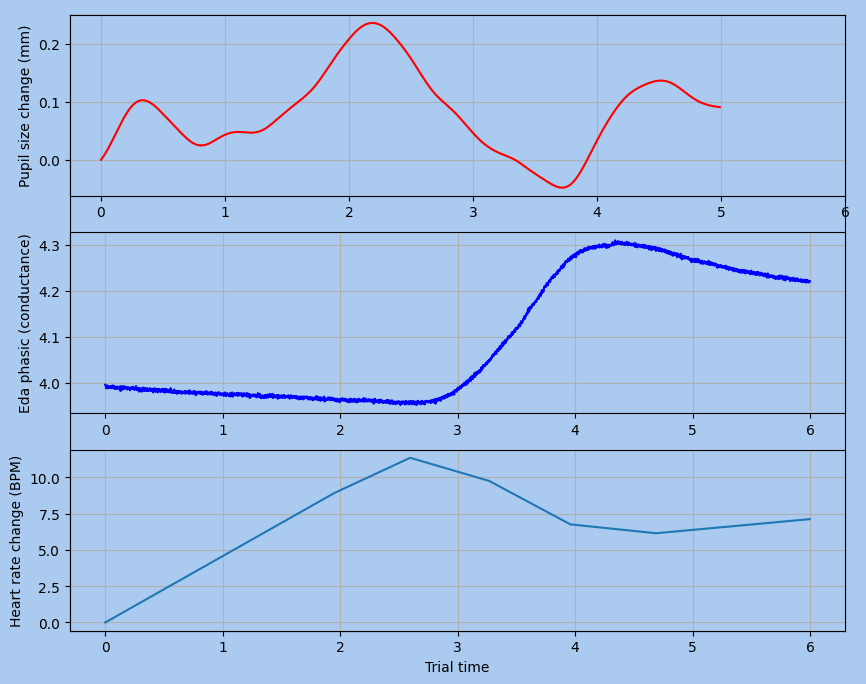

In [54]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

fig.set_facecolor('#AACAEF')
X = np.arange(0, 7)

ax1.plot(X_pupil, pupil, color = 'r')
ax1.set_ylabel('Pupil size change (mm)')
ax1.set_facecolor('#AACAEF')
ax1.set_xticks(X)
ax1.grid()

ax2.plot(X_physio, eda, color = 'b')
ax2.set_ylabel('Eda phasic (conductance)')
ax2.set_facecolor('#AACAEF')
ax2.grid()
ax3.plot(X_physio, tmp_HR)
ax3.set_ylabel('Heart rate change (BPM)')
ax3.set_facecolor('#AACAEF')
ax3.set_xlabel('Trial time')
ax3.grid()

ax.set_facecolor('#AACAEF')

ax.tick_params(labelcolor='#AACAEF', top=False, bottom=False, left=False, right=False)